# Xgboost time series forcasting with sktime 

Sales forcasting is one ofthe problem case in the real world that able to be solve by the power of data. 
In this notebook we are going to talke about how to forecaste sales data that the data has only one-single data with sktime
on 4 models and more focus on Xgboost untill hyperparameter  tuning.

**content**
- Step 0: import package & data
- step 1: EDA and stationary test
- step 2: sktime (split data & fh)
- step 3: model
- step 4: Time series cross-validation
- step 5: Hyperparameter tuning
 

## step 0 : import package & data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns

In [3]:
from warnings import simplefilter

simplefilter(action="ignore", category=RuntimeWarning)

In [4]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_selection import (ForecastingGridSearchCV, SlidingWindowSplitter)
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

In [5]:
df = pd.read_csv('sktime_data/44g_milk.csv')

df.head()

,date,milk
0,1/2/2021,20
1,1/2/2021,30
2,1/3/2021,4
3,1/4/2021,10
4,1/4/2021,10


## step 1: EDA and stationary test

we will explore in 3 levels as Day, Month and Week

DAY

In [6]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace= True)

In [7]:
df_day = df.resample('D').sum()
df_day = df_day.reset_index(drop=False)

df_day['year'] = df_day['date'].dt.year
df_day['month'] = df_day['date'].dt.month
df_day['week_of_year'] = df_day['date'].dt.week

C:\Users\Mos\AppData\Local\Temp\ipykernel_10572\881322864.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_day['week_of_year'] = df_day['date'].dt.week


In [8]:
df_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          698 non-null    datetime64[ns]
 1   milk          698 non-null    int64         
 2   year          698 non-null    int64         
 3   month         698 non-null    int64         
 4   week_of_year  698 non-null    int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 27.4 KB


In [9]:
df_day.head()

,date,milk,year,month,week_of_year
0,2021-01-02,50,2021,1,53
1,2021-01-03,4,2021,1,53
2,2021-01-04,110,2021,1,1
3,2021-01-05,170,2021,1,1
4,2021-01-06,152,2021,1,1


Saparate year Y2021 and Y2022 df to see heatmap of sales in each day whole year overview by month 

In [10]:
pip install calplot

In [11]:
import calplot

In [12]:
df_day_y21 = df_day[(df_day['year']==2021)]
df_day_y21.set_index('date', inplace= True)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


(<Figure size 1250x170 with 2 Axes>,
 array([<AxesSubplot:ylabel='2021'>], dtype=object))

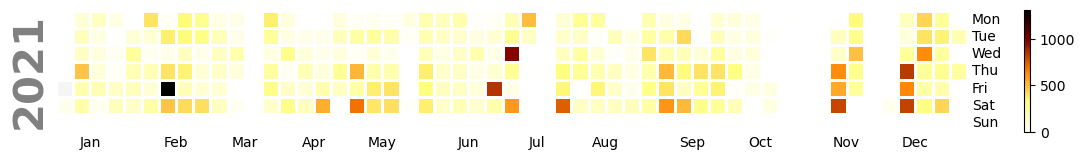

In [13]:
calplot.calplot(df_day_y21['milk'],edgecolor= None, cmap= 'afmhot_r')

In [14]:
df_day_y22 = df_day[(df_day['year']==2022)]
df_day_y22.set_index('date', inplace= True)

(<Figure size 1250x170 with 2 Axes>,
 array([<AxesSubplot:ylabel='2022'>], dtype=object))

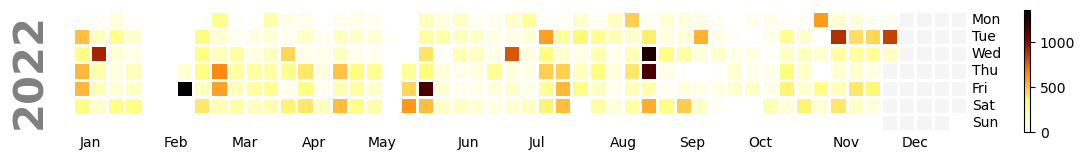

In [15]:
calplot.calplot(df_day_y22['milk'],edgecolor= None, cmap= 'afmhot_r')

As above both of Y21 and Y22, sales was active around three preiod a year. First active was in Feb, second was quite ambiguous in May(Jun) till Aug and last active was in Nov till Dec. Next explore is monthly

MONTH

In [16]:
df_month = df.resample('M').sum()
df_month = df_month.reset_index(drop=False)

df_month['year'] = df_month['date'].dt.year
df_month['month'] = df_month['date'].dt.month
df_month['week_of_year'] = df_month['date'].dt.week

C:\Users\Mos\AppData\Local\Temp\ipykernel_10572\672925259.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_month['week_of_year'] = df_month['date'].dt.week


In [17]:
df_month.head()

,date,milk,year,month,week_of_year
0,2021-01-31,3431,2021,1,4
1,2021-02-28,6852,2021,2,8
2,2021-03-31,3181,2021,3,13
3,2021-04-30,3990,2021,4,17
4,2021-05-31,5373,2021,5,22


pivot df_month to contain Y2021 and Y2022 by month to compare by line graph and cluster bar plot 

In [18]:
eda_df = df_month.pivot(index='month', columns='year', values='milk')

In [19]:
eda_df.head()

year,2021,2022
month,,
1,3431.0,5870.0
2,6852.0,3380.0
3,3181.0,5771.0
4,3990.0,5080.0
5,5373.0,5490.0


<AxesSubplot:xlabel='month'>

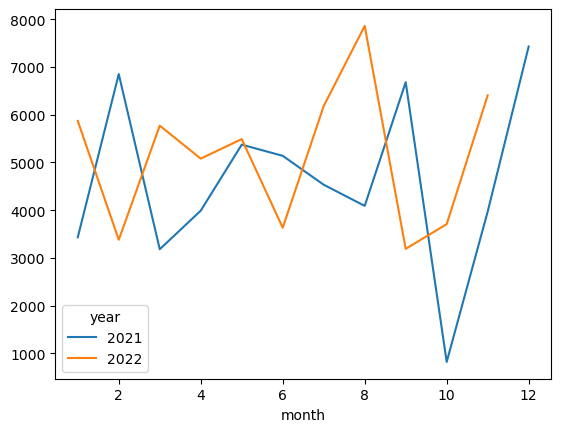

In [20]:
eda_df.plot(kind='line')

<AxesSubplot:xlabel='month'>

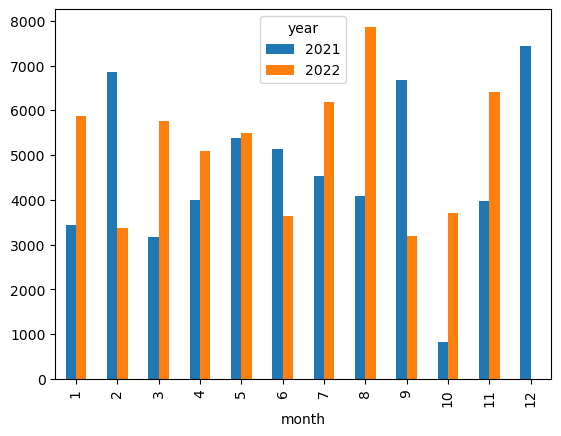

In [21]:
eda_df.plot(kind='bar')

As above, trend line was not big difference. it was quite stable at around 4500–5000 units. I assume abnormal sales was happen in OCT’21.

WEEK

In [22]:
df_week = df.resample('W').sum()
df_week = df_week.reset_index(drop=False)

df_week['year'] = df_week['date'].dt.year
df_week['month'] = df_week['date'].dt.month
df_week['week_of_year'] = df_week['date'].dt.week

C:\Users\Mos\AppData\Local\Temp\ipykernel_10572\3855633309.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_week['week_of_year'] = df_week['date'].dt.week


In [23]:
df_week.set_index('date', inplace= True)

In [24]:
df_week.head()

,milk,year,month,week_of_year
date,,,,
2021-01-03,54,2021,1,53
2021-01-10,1355,2021,1,1
2021-01-17,681,2021,1,2
2021-01-24,471,2021,1,3
2021-01-31,870,2021,1,4


In [25]:
df_week = df.resample('W').sum()
Cmilk_df = df_week[['milk']]

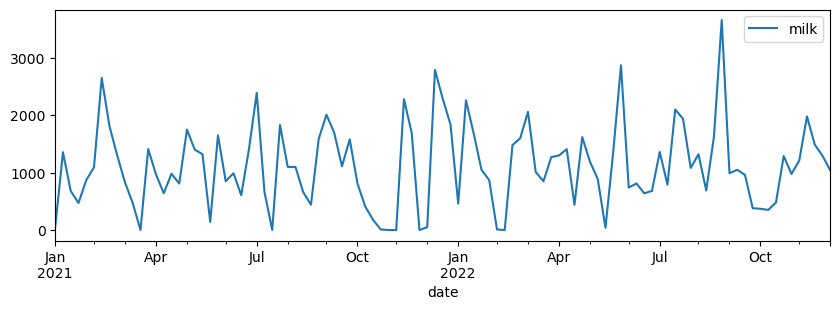

In [26]:
Cmilk_df.plot(figsize= (10,3))
plt.show()

As above we can see two year sales continuously was quite stable at around 1000–1500 units a week. by line plot we can rough inspect this data is stationary. but to make it as a formal summary we step next to test stationary by ADF-test

Stationary test

In [27]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(Cmilk_df.values.flatten())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -7.685424
p-value: 0.000000


The p-value was very less than the significance level of 0.05 and hence we can reject the null hypothesis and take that the series is **stationary**.

## step 2: sktime (split data & fh)

In [28]:
test_size = 12      #12 week(3 month) ahead
window_length = 52  #52 week(1 year) window length

In [29]:
y= Cmilk_df.squeeze() 

y_train, y_test = temporal_train_test_split(y, test_size= test_size)
fh = ForecastingHorizon(y_test.index, is_relative = False)

**temporal_train_test_split:** split data by sequential (last 4 week, last 3 month, last 6 month,..blah blah blah)

In [30]:
y

date
2021-01-03      54
2021-01-10    1355
2021-01-17     681
2021-01-24     471
2021-01-31     870
              ... 
2022-11-06    1210
2022-11-13    1980
2022-11-20    1490
2022-11-27    1294
2022-12-04    1043
Freq: W-SUN, Name: milk, Length: 101, dtype: int64

In [31]:
fh

ForecastingHorizon(['2022-09-18', '2022-09-25', '2022-10-02', '2022-10-09',
               '2022-10-16', '2022-10-23', '2022-10-30', '2022-11-06',
               '2022-11-13', '2022-11-20', '2022-11-27', '2022-12-04'],
              dtype='datetime64[ns]', name='date', freq='W-SUN', is_relative=False)

**ForecastingHorizon:** array of relative or absolute values are specific data points for which we want to generate forecasts

In [32]:
len(y_train)

89

In [33]:
len(y_test)

12

## step 3: model

sktime transform time sequence to supervise and ready to do Machine Learning task, so we can mention now we are working on Regression. I pick up some of Regression model as follow
- AutoARIMA* (a classic Time series technique)
- KNeighborsRegressor
- LinearRegression
- XgbRegressor

#### AUTOARIMA

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='milk'>)

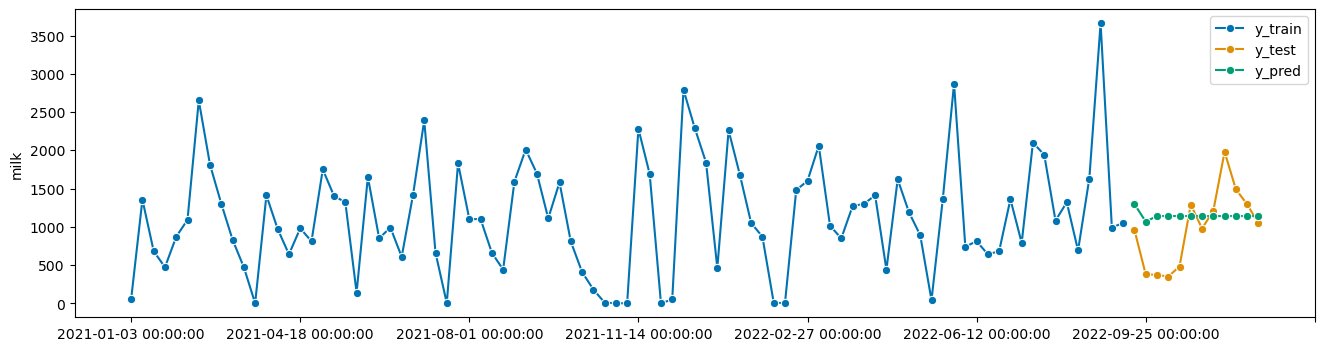

In [34]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(start_p=8, max_p=9, suppress_warnings=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [35]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

MAPE: 0.7570


#### KNeighborsRegressor

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='milk'>)

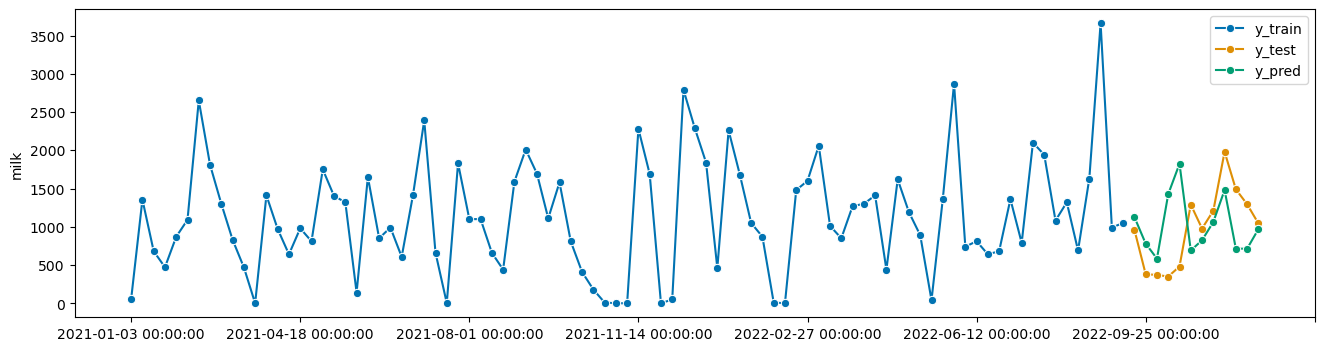

In [36]:
regressor = KNeighborsRegressor(n_neighbors= 3)

forecaster = make_reduction(regressor, strategy="recursive", window_length= window_length)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [37]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

MAPE: 0.8094


#### LinearRegression

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='milk'>)

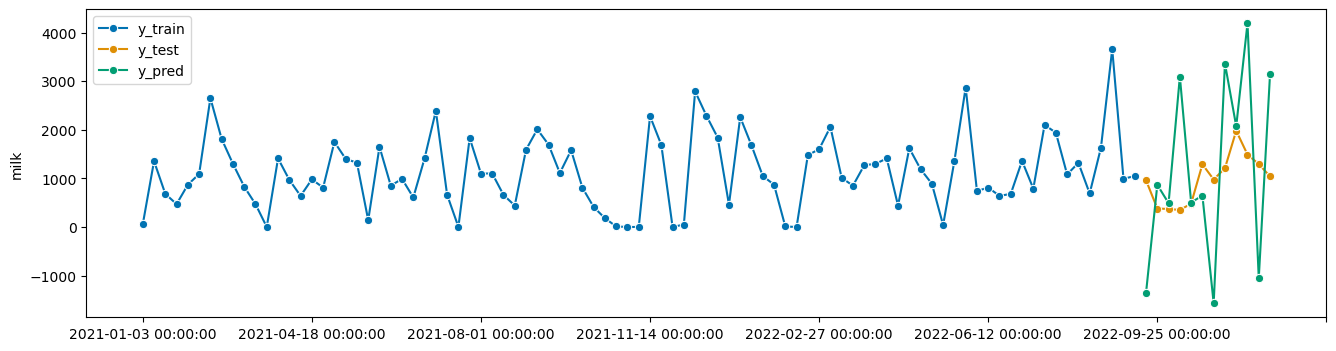

In [38]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()

forecaster = make_reduction(regressor, strategy="recursive", window_length= window_length)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [39]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

MAPE: 1.8744


#### xgboost

In [40]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='milk'>)

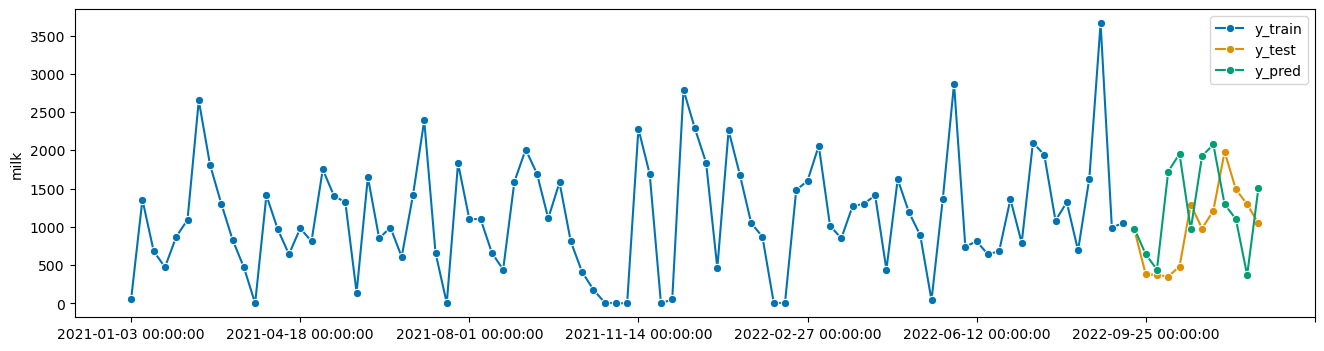

In [41]:
from xgboost import XGBRegressor
regressor = XGBRegressor(objective='reg:squarederror', random_state=42)

forecaster = make_reduction(regressor, strategy="recursive", window_length= window_length)
forecaster.fit(y=y_train)
y_pred = forecaster.predict(fh=fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [42]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

MAPE: 0.9653


model prediction result summary
- AUTOARIMA,can't predict any up and down trend
- **KNeighborsRegressor**, can predict trend of up and down, but it had a gap between actual and predict value. Howevey, it can capture trend line so I make it as candidate model
- LinearRegression, predicted heavy up and down trend. It was the effect of noise data and MAPE was so bad at 1.87
- **XgbRegressor**, can predict up and down trend in a acceptable level, but almost same error as KNeighborsRegressor. However, it can predict so I pick it us as a candidate model to improve

## step 4: Time series cross-validation

In [43]:
from utils import plot_windows

In [44]:
fh = ForecastingHorizon(np.arange(12) + 1)
y_train, y_test = temporal_train_test_split(y, fh=fh)

In [45]:
fh

ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', is_relative=True)

In [46]:
len(y)

101

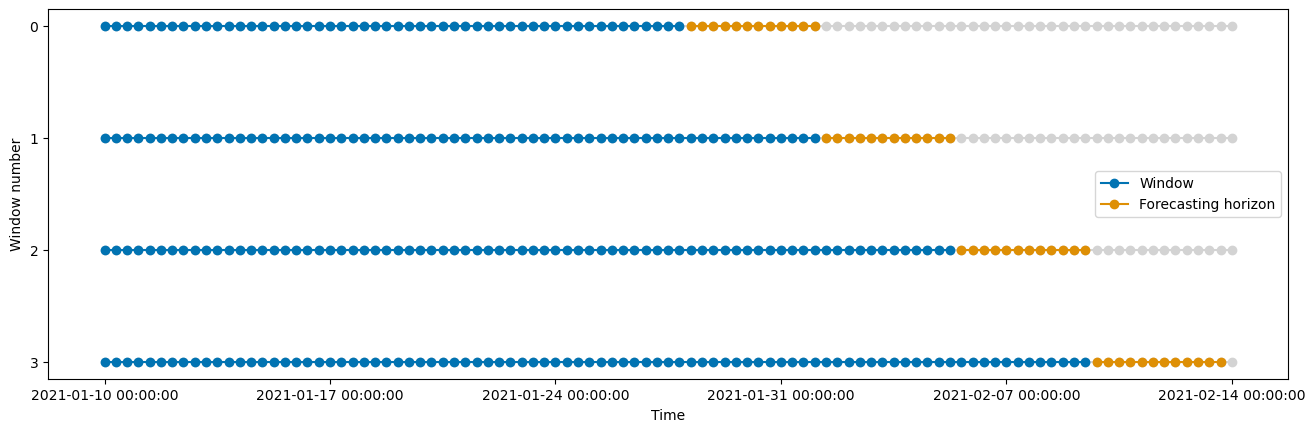

In [47]:
cv = ExpandingWindowSplitter(step_length=12, fh=fh, initial_window= 52)
plot_windows(cv, y.iloc[:])

In [48]:
y.iloc[:]

date
2021-01-03      54
2021-01-10    1355
2021-01-17     681
2021-01-24     471
2021-01-31     870
              ... 
2022-11-06    1210
2022-11-13    1980
2022-11-20    1490
2022-11-27    1294
2022-12-04    1043
Freq: W-SUN, Name: milk, Length: 101, dtype: int64

AutoARIMA: ExpandingWindowSplitter

In [49]:
forecaster = AutoARIMA(start_p=8, max_p=9, suppress_warnings=True)

cv = ExpandingWindowSplitter(step_length=12, fh=fh, initial_window=52)
results = evaluate(
    forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True
)
results.iloc[:, :5].head()

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,3.959949e+17,0.521863,0.010811,52,2021-12-26
1,2.485736e+00,0.555744,0.006775,64,2022-03-20
2,3.839436e-01,1.139547,0.012203,76,2022-06-12
3,7.917354e-01,0.788359,0.007376,88,2022-09-04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


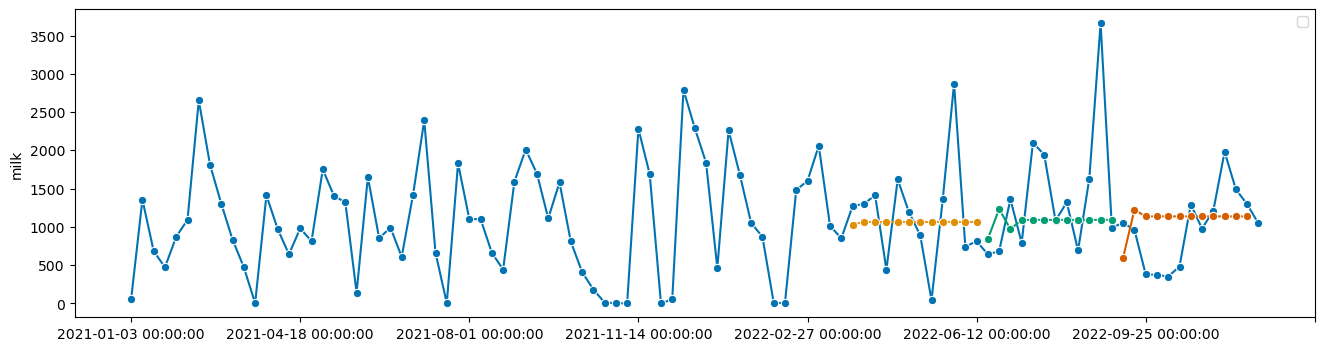

In [50]:
fig, ax = plot_series(
    y,
    results["y_pred"].iloc[1],
    results["y_pred"].iloc[2],
    results["y_pred"].iloc[3],
)
ax.legend();

KNeighborsRegressor: ExpandingWindowSplitter

In [51]:
regressor = KNeighborsRegressor(n_neighbors=3)
forecaster = make_reduction(regressor, strategy="recursive", window_length= window_length)

cv = ExpandingWindowSplitter(step_length=12, fh=fh, initial_window=52)
results = evaluate(
    forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True
)
results.iloc[:, :5].head()

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,NaN,NaN,NaN,52,NaT
1,1.354054,0.002560,1.699628,64,2022-03-20
2,0.477448,0.003768,1.379272,76,2022-06-12
3,0.846698,0.002447,1.377528,88,2022-09-04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


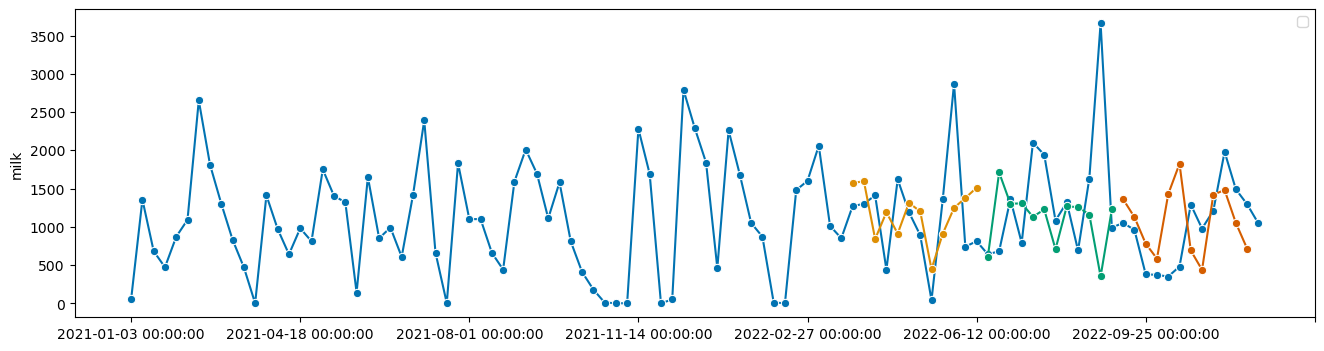

In [52]:
fig, ax = plot_series(
    y,
    results["y_pred"].iloc[1],
    results["y_pred"].iloc[2],
    results["y_pred"].iloc[3],  
)
ax.legend();

LinearRegression: ExpandingWindowSplitter

In [53]:
regressor = LinearRegression()
forecaster = make_reduction(regressor, strategy="recursive", window_length= window_length)

cv = ExpandingWindowSplitter(step_length=12, fh=fh, initial_window=52)
results = evaluate(
    forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True
)
results.iloc[:, :5].head()

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,NaN,NaN,NaN,52,NaT
1,1.518952,0.003188,0.003898,64,2022-03-20
2,0.661834,0.003957,0.003636,76,2022-06-12
3,1.936779,0.003311,0.002624,88,2022-09-04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


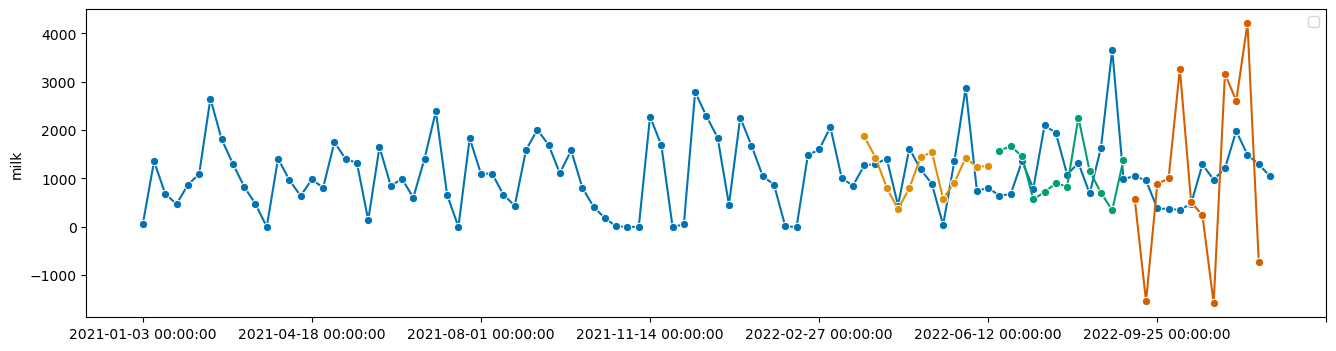

In [54]:
fig, ax = plot_series(
    y,
    results["y_pred"].iloc[1],
    results["y_pred"].iloc[2],
    results["y_pred"].iloc[3],  
)
ax.legend();

XGBRegressor ExpandingWindowSplitter

In [55]:
regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster = make_reduction(regressor, strategy="recursive", window_length= window_length)

cv = ExpandingWindowSplitter(step_length=12, fh=fh, initial_window=52)
results = evaluate(
    forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True
)
results.iloc[:, :5].head()

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,NaN,NaN,NaN,52,NaT
1,2.705155,0.054349,0.032775,64,2022-03-20
2,0.592396,0.073280,0.050077,76,2022-06-12
3,0.531919,0.087218,0.049314,88,2022-09-04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


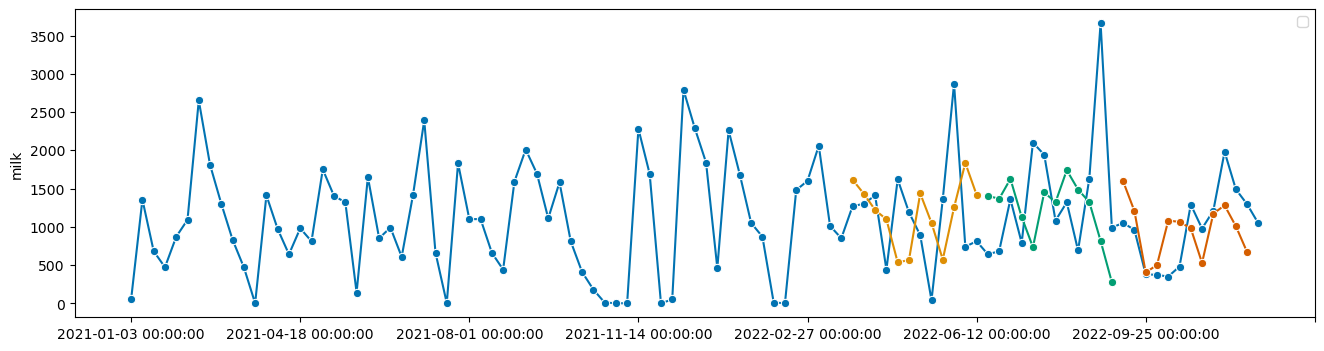

In [56]:
fig, ax = plot_series(
    y,
    results["y_pred"].iloc[1],
    results["y_pred"].iloc[2],
    results["y_pred"].iloc[3],  
)
ax.legend();

as above XgbRegressor: ExpandingWindowSplitter prediction line trend was getting close to the train line compare with KNeighborsRegressor. By result summary table MAPE was getting better by len_train_window

## step5: Hyperparameter tuning

In [57]:
from sktime.forecasting.model_selection import (ForecastingGridSearchCV,
                                                SlidingWindowSplitter)

param_grid = {
    'estimator__max_depth': [3, 6, 10, 15],
    'estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'estimator__colsample_bytree': np.arange(0.4, 1.0),
    'estimator__n_estimators': [100, 500, 1000]
}

regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster = make_reduction(regressor, strategy="recursive")

cv = ExpandingWindowSplitter(step_length=12, fh=fh, initial_window=52)
gscv = ForecastingGridSearchCV(
    forecaster, cv=cv, param_grid=param_grid, strategy="refit"
)

In [58]:
gscv.fit(y_train)

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', is_relative=True),
                                                   initial_window=52,
                                                   step_length=12),
                        forecaster=RecursiveTabularRegressionForecaster(estimator=XGBRegressor(base_score=None,
                                                                                               booster=None,
                                                                                               callbacks=None,
                                                                                               colsample_bylevel=None,
                                                                                               colsample_bynode=None,
                                                                                               colsample_bytree=None,...
                                                                                               max_depth=None,
                                                                                               max_leaves=None,
                                                                                               min_child_weight=None,
                                                                                               missing=nan,
                                                                                               monotone_constraints=None,
                                                                                               n_estimators=100,
                                                                                               n_jobs=None,
                                                                                               num_parallel_tree=None,
                                                                                               predictor=None,
                                                                                               random_state=42, ...)),
                        param_grid={'estimator__colsample_bytree': array([0.4]),
                                    'estimator__learning_rate': [0.01, 0.1, 0.2,
                                                                 0.3],
                                    'estimator__max_depth': [3, 6, 10, 15],
                                    'estimator__n_estimators': [100, 500,
                                                                1000]})

In [59]:
y_pred = gscv.predict(fh)

In [60]:
gscv.best_params_

{'estimator__colsample_bytree': 0.4,
 'estimator__learning_rate': 0.01,
 'estimator__max_depth': 6,
 'estimator__n_estimators': 100}

In [61]:
print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

MAPE: 0.5114


MAPE was better from begining (single model) at 0.9653, ExpandingWindowSplitter (Validation) last len at  0.5319 and last perfomance (Hyperparameter tuning) was 0.5114. Hyperparameter tuning can improve 47% improve from single model and 4% from Validation.